In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.utils import cross_group_predict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

import warnings
warnings.simplefilter("ignore")

import pickle as pkl

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [78]:
raw_folder_path = "../data/raw"
raw_csv = f"{raw_folder_path}/spectra_241016.csv"
raw_df = pd.read_csv(raw_csv)

label_csv = f"{raw_folder_path}/label_241016.csv"
label_df = pd.read_csv(label_csv)

label_df = label_df.pivot(index=['lot_id','lot_name'],columns='property_name',values='property_value').reset_index()

raw_df.shape, label_df.shape

((1036, 11), (330, 8))

In [79]:
label_df 

property_name,lot_id,lot_name,BrownSug_Adulteration,Farm,Grade,Mixed_Pure,Preservative,Sugar Type
0,73200,SGProj_Spl-1,PureKD,PNG,A,PureKD,Sulfite,NonDwarf (PureKD)
1,73201,SGProj_Spl-2,PureKD,PNG,A,PureKD,Sulfite,NonDwarf (PureKD)
2,73202,SGProj_Spl-3,PureKD,PNG,A,PureKD,Sulfite,NonDwarf (PureKD)
3,73203,SGProj_Spl-4,PureKD,PNG,A,PureKD,Sulfite,NonDwarf (PureKD)
4,73204,SGProj_Spl-5,PureKD,PNG,A,PureKD,Sulfite,NonDwarf (PureKD)
...,...,...,...,...,...,...,...,...
325,73525,SGProj_Spl-326,PureKD,BW,A3,PureKD,Chalk,NonDwarf (PureKD)
326,73526,SGProj_Spl-327,PureKD,BW,A3,PureKD,Chalk,NonDwarf (PureKD)
327,73527,SGProj_Spl-328,PureKD,BW,A3,PureKD,Chalk,NonDwarf (PureKD)
328,73528,SGProj_Spl-329,PureKD,BW,A3,PureKD,Chalk,NonDwarf (PureKD)


# train-test split by date

In [80]:
val_df = raw_df[raw_df['date_scanned'] > 1727654400]
raw_df = raw_df[raw_df['date_scanned'] < 1727654400]
raw_df.shape, val_df.shape

((940, 11), (96, 11))

In [81]:
label_train = label_df[label_df['lot_id'].isin(raw_df['lot_id'])]
label_train.to_csv('../data/train_list.csv')

In [82]:
label_df = label_df.drop(columns = ['lot_name','BrownSug_Adulteration','Farm','Mixed_Pure','Preservative','Sugar Type'])

X_train, y_train = preprocess(raw_df, label_df,  wavelengths=WAVELENGTHS_3NM_V1)

X_train.shape, y_train.shape

((940, 191), (940, 1))

# Classify

In [83]:
encoder = LabelEncoder()
y_train_encoded = pd.Series(
    encoder.fit_transform(y_train),
    index = y_train.index
)

pkl.dump(encoder, open("../models/automl/encoder.pkl", "wb"))

X_train.shape, y_train_encoded.shape

((940, 191), (940,))

In [84]:
trainer = AutoML_v4(task_type = "classify")
trainer.fit(X_train, y_train_encoded)
pkl.dump(trainer, open(
    "../models/automl/trainer.pkl", "wb"
))

100%|██████████| 200/200 [02:06<00:00,  1.59trial/s, best loss: 0.13482142857142865]


In [100]:
trainer=pkl.load(open('../models/automl/trainer.pkl','rb'))

In [101]:
trainer.get_best_trial()

{'state': 2,
 'tid': 137,
 'spec': None,
 'result': {'loss': 0.13482142857142865,
  'cv_results': {'train_balanced_accuracy': 0.9195262959402992,
   'test_balanced_accuracy': 0.8651785714285714,
   'train_f1_micro': 0.8946696880614077,
   'test_f1_micro': 0.8471275559883155,
   'train_precision_micro': 0.8946696880614078,
   'test_precision_micro': 0.8471275559883155,
   'train_recall_micro': 0.8946696880614078,
   'test_recall_micro': 0.8471275559883155},
  'time_taken': 0.47954273223876953,
  'pipeline': Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=13)),
                  ('Scaler', StandardScaler(with_std=False)),
                  ('PCA', PCA(n_components=23, random_state=42)),
                  ('QDA', QuadraticDiscriminantAnalysis())]),
  'status': 'ok',
  'exception': None},
 'misc': {'tid': 137,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'C': [],
   'alpha': [],
   'ccp_alpha': [],
   'classifier': [137],
   'dimred_choice': [],
 

In [102]:
trainer.get_pipeline()

Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=23, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

In [88]:
platform_trainer=pkl.load(open('../models/platform/6089/prediction/trainer.pkl','rb'))

In [89]:
platform_trainer.get_best_trial()

{'state': 2,
 'tid': 137,
 'spec': None,
 'result': {'loss': 0.13482142857142865,
  'cv_results': {'train_balanced_accuracy': 0.9195262959402992,
   'test_balanced_accuracy': 0.8651785714285714,
   'train_f1_micro': 0.8946696880614077,
   'test_f1_micro': 0.8471275559883155,
   'train_precision_micro': 0.8946696880614078,
   'test_precision_micro': 0.8471275559883155,
   'train_recall_micro': 0.8946696880614078,
   'test_recall_micro': 0.8471275559883155},
  'time_taken': 0.38838720321655273,
  'pipeline': Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=13)),
                  ('Scaler', StandardScaler(with_std=False)),
                  ('PCA', PCA(n_components=23, random_state=42)),
                  ('QDA', QuadraticDiscriminantAnalysis())]),
  'status': 'ok',
  'exception': None},
 'misc': {'tid': 137,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'C': [],
   'alpha': [],
   'ccp_alpha': [],
   'classifier': [137],
   'dimred_choice': [],
 

In [90]:
platform_trainer.get_pipeline()

Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=23, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

# training metrics

In [91]:
grouped_X = X_train.groupby(X_train.index).mean()
grouped_y = y_train_encoded.groupby(y_train_encoded.index).mean()

train_pred = trainer.predict(grouped_X)

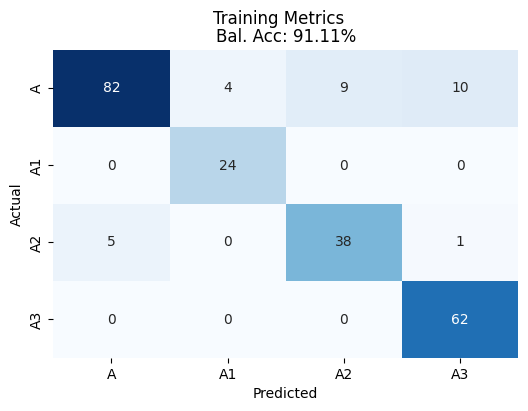

In [92]:
cnfm = confusion_matrix(grouped_y, train_pred)
bal_acc = balanced_accuracy_score(grouped_y, train_pred)

fig = plt.figure(figsize = (6, 4))
fig.suptitle("Training Metrics")
ax = fig.add_subplot(111)

cnfm_settings = {
    "cmap": "Blues",
    "cbar": None,
    "annot": True,
    "fmt": ".0f",
    "xticklabels": encoder.classes_,
    "yticklabels": encoder.classes_,
}

ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")
sns.heatmap(
    cnfm,
    ax = ax,
    **cnfm_settings
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
# plt.tight_layout()
plt.show()

In [93]:
f1score = f1_score(grouped_y, train_pred, average=None, labels=encoder.transform(list(encoder.classes_)))
f1score

array([0.85416667, 0.92307692, 0.83516484, 0.91851852])

# cross val predict

In [94]:
grouped_X = X_train.groupby(X_train.index).mean()
grouped_y = y_train_encoded.groupby(y_train_encoded.index).mean()

# Calculate CV confusion matrix
kfold = StratifiedGroupKFold(n_splits = 3)

grouped_cv_pred = cross_group_predict(
    trainer.get_pipeline(), 
    X = X_train,
    y = y_train_encoded,
    cv = kfold,
    groups = X_train.index
)



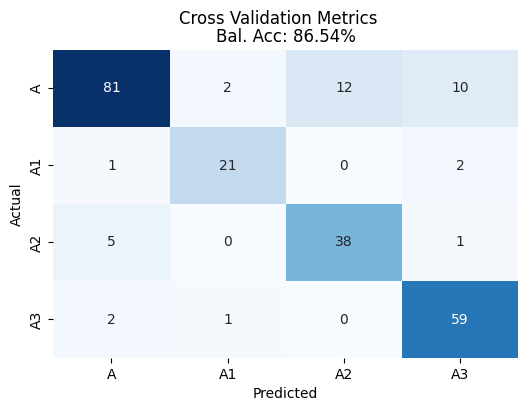

In [95]:
cnfm = confusion_matrix(grouped_y, grouped_cv_pred)
bal_acc = balanced_accuracy_score(grouped_y, grouped_cv_pred)

fig = plt.figure(figsize = (6, 4))
fig.suptitle("Cross Validation Metrics")
ax = fig.add_subplot(111)

ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

cnfm_settings = {
    "cmap": "Blues",
    "cbar": None,
    "annot": True,
    "fmt": ".0f",
    "xticklabels": encoder.classes_,
    "yticklabels": encoder.classes_,
}

sns.heatmap(
    cnfm,
    ax = ax,
    **cnfm_settings
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# plt.tight_layout()
plt.show()

In [103]:
f1score = f1_score(grouped_y, grouped_cv_pred, average=None, labels=encoder.transform(list(encoder.classes_)))
f1score

array([0.83505155, 0.875     , 0.80851064, 0.88059701])

# blinds predict

In [96]:
X_val, y_val = preprocess(val_df, label_df,  wavelengths=WAVELENGTHS_3NM_V1)

X_val.shape, y_val.shape

((96, 191), (96, 1))

In [97]:
y_val_encoded = pd.Series(
    encoder.transform(y_val),
    index = y_val.index
)

grouped_X_val = X_val.groupby(X_val.index).mean()
grouped_y_val = y_val_encoded.groupby(y_val_encoded.index).mean()

val_pred = trainer.predict(grouped_X_val)

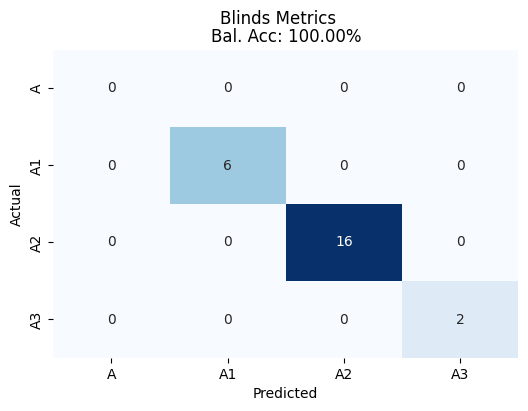

In [98]:
cnfm = confusion_matrix(grouped_y_val, val_pred, labels = encoder.transform(list(encoder.classes_)))
bal_acc = balanced_accuracy_score(grouped_y_val, val_pred)

fig = plt.figure(figsize = (6, 4))
fig.suptitle("Blinds Metrics")
ax = fig.add_subplot(111)

ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

cnfm_settings = {
    "cmap": "Blues",
    "cbar": None,
    "annot": True,
    "fmt": ".0f",
    "xticklabels": encoder.classes_,
    "yticklabels": encoder.classes_,
}

sns.heatmap(
    cnfm,
    ax = ax,
    **cnfm_settings
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# plt.tight_layout()
plt.show()

In [99]:
decoded_cnfm = pd.DataFrame(
    confusion_matrix(grouped_y, train_pred),
    index = encoder.classes_,
    columns = encoder.classes_
)

decoded_cnfm.to_csv("../models/automl/train_cnfm.csv")
decoded_cnfm

,A,A1,A2,A3
A,82,4,9,10
A1,0,24,0,0
A2,5,0,38,1
A3,0,0,0,62
